# Quantum Key Distribution

## Contents

1. Introduction
2. Protocol Overview
3. Qiskit Example: Without Interception
4. Qiskit Example: With Interception
5. Risk Analysis

## 1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the internet), it is essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this textbook, we will have to believe that Alice and Bob having a secret key that no one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fiber-optic cable, through which we can send individual photons (particles of light). Photons have a property called _polarisation,_ and this polarisation can be one of two states. We can use this to represent a qubit.


## 2. Protocol Overview  

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

In [1]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator


import matplotlib.ticker as tck
from numpy.random import randint


/var/folders/jh/9wz4xz9j17x2c_b3x0zgtnv40000gn/T/ipykernel_4805/2089120801.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


If Alice prepares a qubit in the state $|+\rangle$ (`0` in the $X$-basis), and Bob measures it in the $X$-basis, Bob is sure to measure `0`:

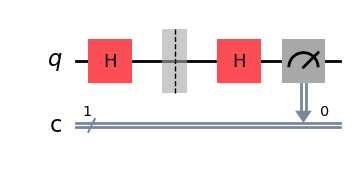

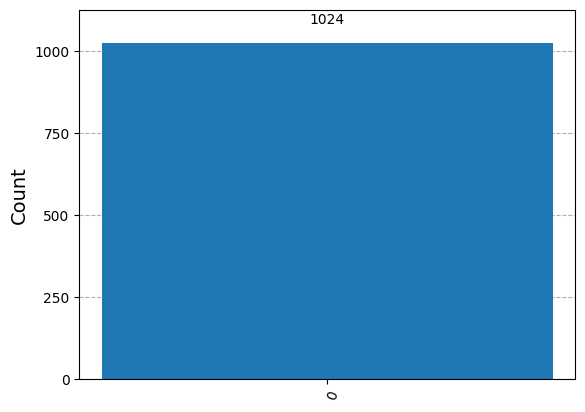

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw('mpl'))
aer_sim = AerSimulator()
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the $Z$-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

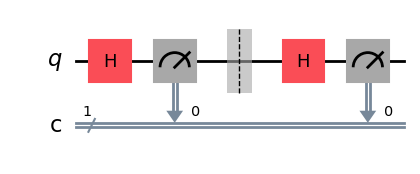

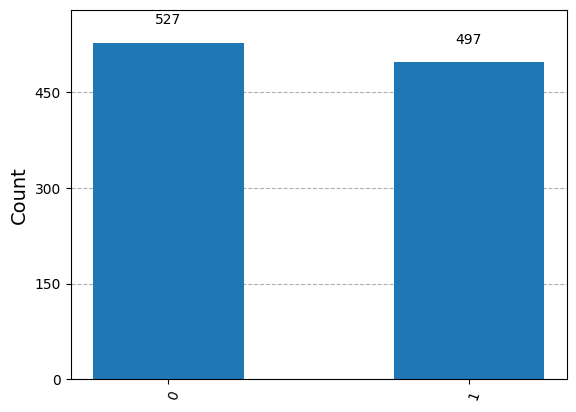

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw('mpl'))
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel.

The quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. It is roughly as follows:

**- Step 1**

Alice chooses a string of random bits, e.g.:

`1000101011010100`

And a random choice of basis for each bit:

`ZZXZXXXZXZXXXXXX`

Alice keeps these two pieces of information private to herself. 

**- Step 2**

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states $|0\rangle$, $|1\rangle$, $|+\rangle$ or $|-\rangle$, chosen at random. In this case, the string of qubits would look like this:

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

This is the message she sends to Bob.

**- Step 3**

Bob then measures each qubit at random, for example, he might use the bases:

`XZZZXZXZXZXZZZXZ`

And Bob keeps the measurement results private.

**- Step 4**

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

**- Step 5**

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.


## 3. Qiskit Example: Without Interception

Let’s first see how the protocol works when no one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. As always, let's start by importing everything we need:

To generate pseudo-random keys, we will use the `randint` function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0:

In [ ]:
np.random.seed(seed=0)

We will call the length of Alice's initial message `n`. In this example, Alice will send a message 100 qubits long:

In [ ]:
n = 100

### 3.1 Step 1:

Alice generates her random set of bits:

In [ ]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

### 3.2 Step 2:

Alice chooses to encode each bit on qubit in the $X$ or $Z$-basis at random, and stores the choice for each qubit in `alice_bases`. In this case, a `0` means "prepare in the $Z$-basis", and a `1` means "prepare in the $X$-basis":

In [ ]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

Alice also keeps this knowledge private:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [ ]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        # write the circuit here which encode bits[i] in base bases[i] (Alice encoding)
        message.append(qc)
    return message

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

We can see that the first bit in `alices_bits` is `0`, and the basis she encodes this in is the $X$-basis (represented by `1`):

In [ ]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

And if we view the first circuit in `message` (representing the first qubit in Alice's message), we can verify that Alice has prepared a qubit in the state $|+\rangle$:

In [ ]:
message[0].draw('mpl')

As another example, we can see that the fourth bit in `alice_bits` is `1`, and it is encoded in the $Z$-basis, Alice prepares the corresponding qubit in the state $|1\rangle$:

In [ ]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw('mpl')

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

### 3.3 Step 3:

Bob then measures each qubit in the $X$ or $Z$-basis at random and stores this information:

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Below, the function `measure_message` applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [ ]:
sim = AerSimulator()

result = sim.run(qc, shots=1).result()
result.get_counts()
bob_bases = randint(2, size=n)
bob_bases

In [ ]:
def measure_message(message, bases):
    sim = AerSimulator()
    measurements = []
    for q in range(n):
        qc = message[q]
        # write the code to measure the qubit in the correct basis
        
        # then we measure it
        result = sim.run(qc, shots=1).result()
        counts = result.get_counts()
        measured_bit = 0 if '0' in counts.keys() else 1
        measurements.append(measured_bit)
    return measurements

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

We can see that the circuit in `message[0]` (representing the 0th qubit) has had an $X$-measurement added to it by Bob:

In [ ]:
message[0].draw('mpl')

Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result `0`. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'. 

In [ ]:
message[6].draw('mpl')

In [ ]:
print(bob_results)

Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

### 3.4 Step 4:

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_results` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `remove_garbage` that does this for us:

In [ ]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |

### 3.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [ ]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [ ]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

If the protocol has worked correctly without interference, their samples should match:

In [ ]:
bob_sample == alice_sample

If their samples match, it means (with high probability) `alice_key == bob_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [ ]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

## 4. Qiskit Example: *With* Interception

Let’s now see how Alice and Bob can tell if Eve has been trying to listen in on their quantum message. We repeat the same steps as without interference, but before Bob receives his qubits, Eve will try and extract some information from them. Let's set a different seed so we get a specific set of reproducible 'random' results:

In [ ]:
np.random.seed(seed=3)

### 4.1 Step 1:

Alice generates her set of random bits:

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

### 4.2 Step 2:

Alice encodes these in the $Z$ and $X$-bases at random, and sends these to Bob through Eve's quantum channel:

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

In this case, the first qubit in Alice's message is in the state $|+\rangle$:

In [ ]:
message[0].draw('mpl')

### Interception!

Oh no! Eve intercepts the message as it passes through her channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

We can see the case of qubit 0 below; Eve's random choice of basis is not the same as Alice's, and this will change the qubit state from $|+\rangle$, to a random state in the $Z$-basis, with 50% probability of $|0\rangle$ or $|1\rangle$:

In [ ]:
message[0].draw('mpl')

### 4.3 Step 3:

Eve then passes on the qubits to Bob, who measures them at random. In this case, Bob chose (by chance) to measure in the same basis Alice prepared the qubit in. Without interception, Bob would be guaranteed to measure `0`, but because Eve tried to read the message he now has a 50% chance of measuring `1` instead.

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw('mpl')

### 4.4 Step 4:

Bob and Alice reveal their basis choices, and discard the useless bits:

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 Step 5:

Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:

In [ ]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

In [ ]:
bob_sample == alice_sample

Oh no! Bob's key and Alice's key do not match. We know this is because Eve tried to read the message between steps 2 and 3, and changed the qubits' states. For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve's interception attempt has failed.

## 5. Risk Analysis

For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match, and Alice sends her vulnerable message through Eve's channel. Let's calculate that chance and see how risky quantum key distribution is.

- For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, she will successfully intercept this bit without introducing any error. There is a 50% chance of this happening.
- If Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is still a 50% chance Bob will measure the value Alice was trying to send. In this case, the interception also goes undetected.
- But if Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is a 50% chance Bob will not measure the value Alice was trying to send, and this *will* introduce an error into their keys.

![risk probability tree](images/qkd_risk.svg)

If Alice and Bob compare 1 bit from their keys, the probability the bits will match is $0.75$, and if so they will not notice Eve's interception. If they measure 2 bits, there is a $0.75^2 = 0.5625$ chance of the interception not being noticed. We can see that the probability of Eve going undetected can be calculated from the number of bits ($x$) Alice and Bob chose to compare:

$$ P(\text{undetected}) = 0.75^x $$

If we decide to compare 15 bits as we did above, there is a 1.3% chance Eve will be undetected. If this is too risky for us, we could compare 50 bits instead, and have a 0.00006% chance of being spied upon unknowingly.

You can retry the protocol again by running the cell below. Try changing `sample_size` to something low and see how easy it is for Eve to intercept Alice and Bob's keys.

In [ ]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

# Are you smarter than EVE?

### Try to find better ways to steal information from the message.
Can you do better than Eve?